In [51]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple 

In [52]:
class planet():
    'A planet in our solar system'
   
    
    def __init__(self, semimajor, eccentricity):
        self.x   = np.zeros(2)
        self.v   = np.zeros(2)
        self.a_g = np.zeros(2)
        self.t   = 0.0
        self.dt  = 0.0
        self.a   = semimajor
        self.e   = eccentricity
        self.istep = 0
        
        self.name = ""

In [53]:
solar_system = {'M_sun': 1.0, 'G': 39.4784176043574320}
#units Au, solarmasses, secords ?

In [54]:
def SolarCircularVelocity(p):
    
    G = solar_system['G']
    M = solar_system['M_sun']
    r = (p.x[0]**2 + p.x[1]**2)**0.5
    
    return (G*M/r)**0.5

In [55]:
def SolarGravitationalAcceleration(p): 
    '''This returns the x and y components of the acceleratoin'''
    
    G = solar_system['G']
    M = solar_system['M_sun']
    r = (p.x[0]**2 + p.x[1]**2)**0.5
    
   
    a_grav = -1.0*(G*M/r**2)
    
    if (p.x[0]== 0.0):
        if (p.x[1]>0.0):
            theta = 0.5*np.pi
        
        else:
            theta = 1.5*np.pi

    else:
        theta = np.arctan2(p.x[1], p.x[0])
    
    return a_grav*np.cos(theta), a_grav*np.sin(theta)

In [56]:
def calc_dt(p):
    
    ETA_TIME_STEP = .0004
    

    eta = ETA_TIME_STEP
    
    v = (p.v[0]**2 + p.v[1]**2)**0.5  
    a = (p.a_g[0]**2 + p.a_g[1]**2)**0.5 
    
    dt = eta * np.fmin(1./np.fabs(v),1./np.fabs(a)**0.5)
    
    return dt 

In [57]:
def SetPlanet(p, i):
    
    AU_in_km = 1.495979e+8
    
    v_c = 0.0
    v_e = 0.0
    
    if i == 0:
        
    
        p.a = 57909227.0/ AU_in_km
        p.e = 0.20563593
        p.name = 'Mercury'
        
    elif i ==1:
        
        p.a = 108209475.0/ AU_in_km
        p.e = 0.00677672
        p.name = 'Venus'

    elif i==2:
        
        p.a = 1.0 
        p.e = 0.01671123
        p.name = 'Earth'
          
    p.t = 0.0
    p.x[0] = p.a*(1.0-p.e)
    p.x[1] = 0.0
    
    v_c = SolarCircularVelocity(p)
    
    v_e = v_c * (1 + p.e)**0.5 
    
    p.v[0] = 0.0
    p.v[1] = v_e
    

    p.a_g = SolarGravitationalAcceleration(p)
    
    p.dt = calc_dt(p)

In [58]:
def x_first_step(x_i,v_i,a_i,dt):
     
    return x_i + 0.5*v_i*dt + 0.25*a_i*dt**2

In [59]:
def v_full_step(v_i, a_ipoh, dt):
    
    return v_i + a_ipoh*dt

In [60]:
def x_full_step(x_ipoh, v_ipl, a_ipoh, dt):
    
    return x_ipoh + v_ipl*dt

In [61]:
def SaveSolarSystem(p, n_planets, t, dt, istep, ndim):
 
    for i in range(n_planets):
        
        fname = "planet.%s.txt" % p[i].name
        
        if(istep==0):
            fp = open(fname,"w")
        else:
            fp = open(fname,"a")
            
        v_drift = np.zeros(ndim)
        
        for k in range(ndim):
            v_drift[k] = p[i].v[k] + 0.5*p[i].a_g[k]*p[i].dt
            
        s = "%6d\t%6.5f\t%6.5f\t%6d\t%6.5f\t%6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\n" % \
            (istep,t,dt,p[i].istep,p[i].t,p[i].dt,p[i].x[0],p[i].x[1],v_drift[0],v_drift[1], \
             p[i].a_g[0], p[i].a_g[1])

        fp.write(s)
        fp.close()


In [69]:
def EvolveSolarSystem(p,n_planets,t_max):
    ndim = 2
    
    dt = 0.5/365.25
    t = 0.0
    istep = 0
    #save our initial conditions
    
    SaveSolarSystem(p,n_planets,t,dt,istep,ndim)
    
    #begin a loop over the global timescale
    
    while(t<t_max):        
        if(t+dt>t_max):
            dt = t_max - t # limit the step to align with t_max        
            #evolve each planet
            
        for i in range(n_planets):
            
            while(p[i].t<t+dt):
                
                #take the first step according to a verlet scheme
                
                if(p[i].istep==0):
                    
                    #take the first step
                    for k in range(ndim):
                        
                        p[i].x[k] = x_first_step(p[i].x[k],p[i].v[k],p[i].a_g[k],p[i].dt)
                        
                    #update the acceleration
                    
                    p[i].a_g = SolarGravitationalAcceleration(p[i])
                    
                    #update the time by 1/2dt
                    p[i].t += 0.5*p[i].dt
                    
                    #update the timestep
                    
                    p[i].dt = calc_dt(p[i])
                    
                    #continue with a normal step
                    #limit the planet’s timestep to align with the global step
                
                if(p[i].t + p[i].dt > t+dt):
                    p[i].dt = t + dt - p[i].t
                    #evolve the velocity
                for k in range(ndim):
                    p[i].v[k] = v_full_step(p[i].v[k],p[i].a_g[k],p[i].dt)
                    #evolve the position
                for k in range(ndim):
                    p[i].x[k] = x_full_step(p[i].x[k],p[i].v[k],p[i].a_g[k],p[i].dt)
                    #update the acceleration
                    
                p[i].a_g = SolarGravitationalAcceleration(p[i])
                #update the time
                p[i].t += p[i].dt
                #compute the new timestep
                p[i].dt = calc_dt(p[i])
                #update the integer timestep
                p[i].istep += 1
                #update the global system time
                
            t+=dt
        #update the global timestep number
            istep += 1   #output the current state
            SaveSolarSystem(p,n_planets,t,dt,istep,ndim)
    print('Time t = ', t)
    print('Maximum t = ',t_max)
    print('Number of steps = ',istep)

 



In [63]:
def read_twelve_arrays(fname): 
    fp = open(fname, 'r')  #fr file pointer, representation of info in file 
    fl = fp.readlines() #built in function read all the lines, retures array, the elements in array are strnigs 
    n = len(fl) 
    
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n)
    f = np.zeros(n)
    g = np.zeros(n)
    h = np.zeros(n)
    j = np.zeros(n)
    k = np.zeros(n)
    l = np.zeros(n)
    m = np.zeros(n) #have n elements, # of lines as the length of the arrayin file 
    p = np.zeros(n) #each array is a coloum in the file 
    
    for i in range(n): #loop through file 
        a[i] = float(fl[i].split()[0]) #fl is the array, each element is a line in the file, fl[i] is a line 
        b[i] = float(fl[i].split()[1]) #stings have ''split' natural split (series of tabs) they will be seperated out
        c[i] = float(fl[i].split()[2]) #ex: sentance each word in the sentance (each element is a word)
        d[i] = float(fl[i].split()[3]) #12 coloummbs 0 entry in the 1st colomn..? 
        f[i] = float(fl[i].split()[4]) #split into 12 strings, 12 coloums seperated by tabs 
        g[i] = float(fl[i].split()[5]) #converted to a float 
        h[i] = float(fl[i].split()[6]) #each read in from the text file will be converted into a float 
        j[i] = float(fl[i].split()[7])
        k[i] = float(fl[i].split()[8])
        l[i] = float(fl[i].split()[9])
        m[i] = float(fl[i].split()[10])
        p[i] = float(fl[i].split()[11])
        
    return a,b,c,d,f,g,h,j,k,l,m,p
        

In [70]:
#set the number of planets 
#earth stats on the x-axis wit y =0 

n_planets = 3 

#set the max time of the simulation 
t_max = 2.0

#create empty list of planets 
p = []

#set the planets 
for i in range(n_planets): 
    
    #create an empty planet 
    ptmp = planet(0.0,0.0)
    
    #set the planet properties 
    SetPlanet(ptmp, i)
    
    #remember the planet 
    p.append(ptmp)
    
#evolve the solar system 
EvolveSolarSystem(p, n_planets, t_max)

Time t =  2.000000000000041
Maximum t =  2.0
Number of steps =  1464


In [65]:
fname = "planet.Mercury.txt"
istepMg,tMg,dtMg,istepM,tM,dtM,xM,yM,vxM,vyM,axM,ayM = read_twelve_arrays(fname)

In [66]:
fname = "planet.Venus.txt"
istepVg,tVg,dtVg,istepV,tV,dtV,xV,yV,vx,vyV,axV,ayV = read_twelve_arrays(fname)

In [67]:
fname = "planet.Earth.txt"
istepEg,tEg,dtEg,istepE,tE,dtE,xE,yE,vxE,vyE,axE,ayE = read_twelve_arrays(fname)

<ipython-input-71-f6127b583853>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


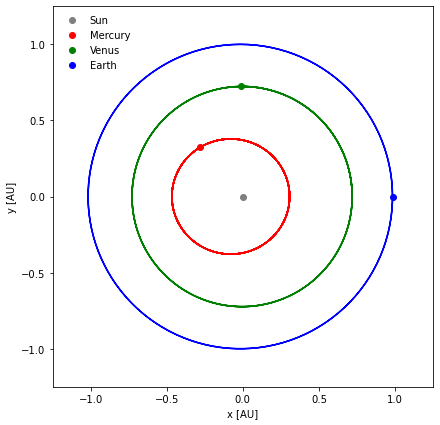

In [71]:
fig = plt.figure(figsize = (7,7))

xSun = [0.0]
ySun = [0.0]


plt.plot(xSun,ySun, 'o', color ='0.5', label = 'Sun')

plt.plot(xM,yM, color= 'red')
plt.plot(xM[-1], yM[-1], 'o', color= 'red', label = 'Mercury')

plt.plot(xV, yV, color ='green')
plt.plot(xV[-1], yV[-1], 'o', color= 'green', label = 'Venus')


plt.plot(xE, yE, color ='blue')
plt.plot(xE[-1], yE[-1], 'o', color= 'blue', label = 'Earth')


plt.xlim([-1.25,1.25])
plt.ylim([-1.25,1.25])

plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.axes().set_aspect('equal')
plt.legend(frameon=False, loc= 2)